In [1]:
# Model name as saved to gcs (it can be found in the model_name config key in wandb)
# wandb run: cool-paper-66
MODEL_NAME = "20220607-141224_07_tacotron_8khz_med_bank_15_epochs__TacotronTTS"
LOCAL_MODEL_DIR = 'copied_models'

In [2]:
# Access project root dir
import git
import os
root_dir = git.Repo('.', search_parent_directories=True).working_tree_dir

os.chdir(root_dir) # Ugly way to get access to imports but this way is also easier for ginconfig

In [37]:
%load_ext autoreload
%autoreload 2


from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython
import tensorflow as tf
import subprocess

import prepare_data
import training
import cloud_training
import utils
import models
import gin

gin.parse_config_file('config/cloud_gpu.gin')
gin.parse_config_file('config/experiments/07_tacotron_8khz_med_bank_15_epochs.gin')
gin.enter_interactive_mode()

fft_length = gin.query_parameter('%fft_length')
frame_length = gin.query_parameter('%frame_length')
frame_step = gin.query_parameter('%frame_step')
sample_rate = gin.query_parameter('%sample_rate')
frames_per_step = gin.query_parameter('%frames_per_step')
mel_bins = gin.query_parameter('%mel_bins')

gsutil = os.path.dirname(gin.query_parameter('gcloud.gcloud_path')) + '/gsutil'
gcs_model_path = gin.query_parameter('gcloud_remote_training.gcs_model_path')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
train_dataset, _ = prepare_data.datasets(target_sample_rate=sample_rate, keep_audio=True, keep_raw_spectrogram=True, keep_transcription=True)

batch = list(train_dataset.take(1))[0]
spectrogram, mel_spec, enc_transcription, audio, raw_spectrogram, transcription = (col[0].numpy() for col in batch)

2022-06-07 16:47:09.316904: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


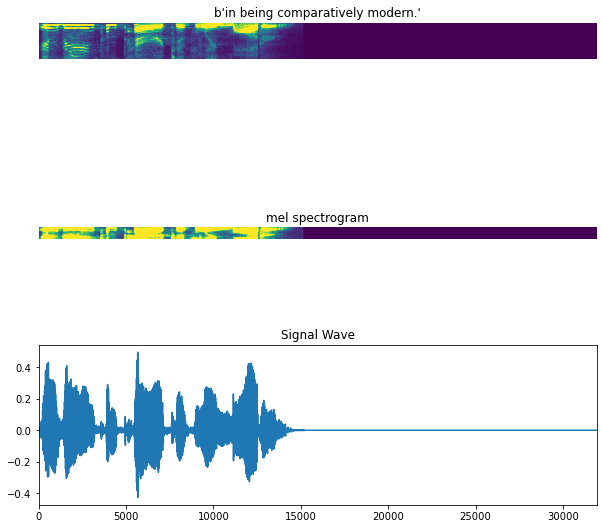

In [5]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
ax.imshow(np.transpose(spectrogram), vmax=1)
ax.set_title(transcription)
ax.axis("off")

ax = plt.subplot(3, 1, 2)
ax.imshow(np.transpose(mel_spec), vmax=1)
ax.set_title('mel spectrogram')
ax.axis("off")

ax = plt.subplot(3, 1, 3)
plt.plot(np.transpose(audio))
ax.set_title("Signal Wave")
ax.set_xlim(0, len(audio))
    
IPython.display.display(IPython.display.Audio(np.transpose(audio), rate=sample_rate))
plt.show()


In [6]:
# Download model and load it
cmd = [gsutil, '-m', 'cp', '-r', gcs_model_path + MODEL_NAME + '*', LOCAL_MODEL_DIR]
res = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [7]:
tts = models.TacotronTTS()
tts.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/final')

# model after first epoch
tts_0 = models.TacotronTTS()
tts_0.load_weights(LOCAL_MODEL_DIR + '/' + MODEL_NAME + '/epoch_0')

In [17]:
GEN_FRAMES = 600

def summarize_mel_stats(mel_spec, new_mel_spec):
    ref_spec = mel_spec[:GEN_FRAMES,:].flatten()
    pred_spec = new_mel_spec[0].numpy().flatten()
    print(f'L1 {np.abs(pred_spec - ref_spec).mean()}')
    return pd.DataFrame({
        'mel_spec': mel_spec[:GEN_FRAMES,:].flatten(),
        'predicted_mel_spec': new_mel_spec[0].numpy().flatten()
    }).describe()

def mel_spec_viz(mel_spec, extra_title=''):
    ax = plt.subplot(2, 1, 1)
    ax.imshow(np.transpose(mel_spec[0]), vmax=1)
    ax.set_title('predicted mel spectrogram' + extra_title)
    ax.axis("off")

    ax = plt.subplot(2, 1, 2)
    ax.imshow(np.transpose(mel_spec[0]))
    ax.set_title('predicted mel spectrogram normalized' + extra_title)
    ax.axis("off")
    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(encoded[0]))
    ax.set_title('encoded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(embed[0]))
    ax.set_title('embedded transcription')
    ax.axis("off")
    plt.show()
    
    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(pre_net[0]))
    ax.set_title('pre_net transcription')
    ax.axis("off")

    plt.show()
    
def encoder_viz(tts, input):
    encoded, _ = tts.tacotron_encoder(input)
    mask = input != tf.constant(-1, dtype=tf.int64)
    embed = tts.tacotron_encoder.embeddings(input)
    pre_net = tts.tacotron_encoder.pre_net(embed)
    conv_bank = tts.tacotron_encoder.cbhg.conv_bank(pre_net)
    pooling = tts.tacotron_encoder.cbhg.pooling(conv_bank)
    conv_proj1 = tts.tacotron_encoder.cbhg.conv_proj1(pooling)
    conv_proj2 = tts.tacotron_encoder.cbhg.conv_proj2(conv_proj1)
    pre_rnn = pre_net + conv_proj2
    rnn = tts.tacotron_encoder.cbhg.rnn_encoder(pre_rnn, mask=mask)

    plt.figure(figsize=(14, 8))
    
    data_sets = [
        encoded, embed, pre_net, conv_bank, pooling,
        conv_proj1, conv_proj2, pre_rnn, rnn
    ]
    captions = [
        'encoded', 'embedded', 'pre_net', 'conv_bank', 'pooling',
        'conv_proj1', 'conv_proj2', 'pre_rnn', 'rnn'
    ]
    
    for ix, (caption, data) in enumerate(zip(captions, data_sets)):
        ax = plt.subplot(1, len(data_sets), ix+1)
        ax.imshow(np.transpose(data[0]))
        ax.set_title(caption)
        ax.axis("off")
        
    plt.show()

In [18]:
# Generate mel_specs

input = tf.expand_dims(enc_transcription[enc_transcription!=-1], 0)
new_mel_spec = tts.decode(input, GEN_FRAMES // frames_per_step)
new_mel_spec_0 = tts_0.decode(input, GEN_FRAMES // frames_per_step)

In [19]:
summarize_mel_stats(mel_spec, new_mel_spec)

L1 0.7539927363395691


,mel_spec,predicted_mel_spec
count,12000.000000,12000.0
mean,0.753993,0.0
std,0.702490,0.0
min,0.000000,0.0
25%,0.157966,0.0
50%,0.609055,0.0
75%,1.121389,0.0
max,3.742443,0.0


In [20]:
summarize_mel_stats(mel_spec, new_mel_spec_0)

L1 0.7539824843406677


,mel_spec,predicted_mel_spec
count,12000.000000,12000.000000
mean,0.753993,0.000015
std,0.702490,0.000211
min,0.000000,0.000000
25%,0.157966,0.000000
50%,0.609055,0.000000
75%,1.121389,0.000000
max,3.742443,0.014068


In [21]:
mel_spec.shape

(994, 20)

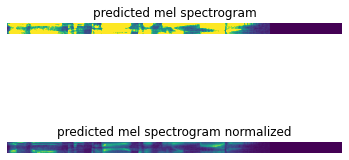

In [22]:
mel_spec_viz([mel_spec[:GEN_FRAMES,:]])

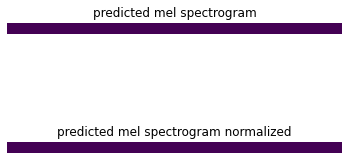

In [23]:
mel_spec_viz(new_mel_spec)

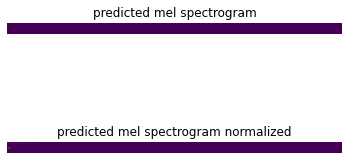

In [25]:
mel_spec_viz(new_mel_spec_0)

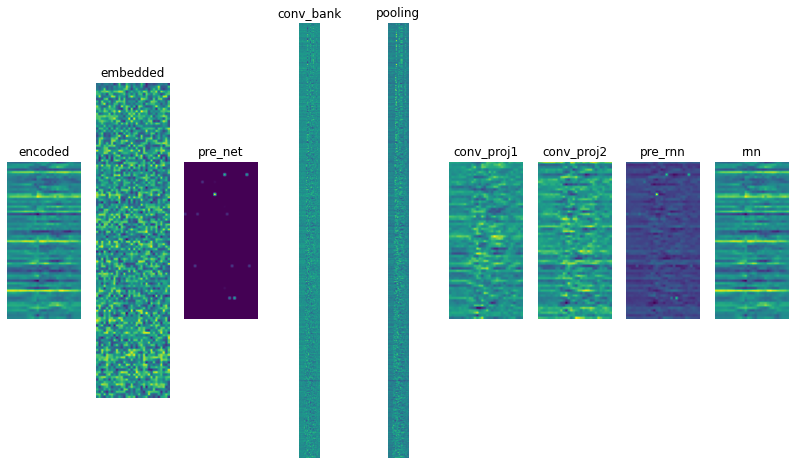

In [26]:
encoder_viz(tts, input)

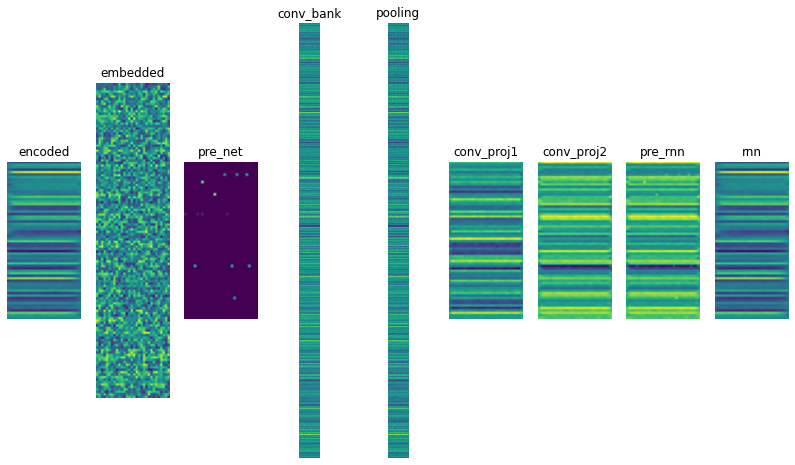

In [27]:
encoder_viz(tts_0, input)

In [29]:
def visualize_attention_states(att_rnn_states):
    data = tf.concat([s[0] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('cell states')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[1] for s in att_rnn_states], 0)

    plt.figure(figsize=(10, 8))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention')
    ax.axis("off")
    plt.show()
    
    data = tf.concat([s[2] for s in att_rnn_states], 0)

    plt.figure(figsize=(16, 14))

    ax = plt.subplot(1, 1, 1)
    ax.imshow(np.transpose(data[:,:]))
    ax.set_title('attention state (alignments)')
    ax.axis("off")
    plt.show()

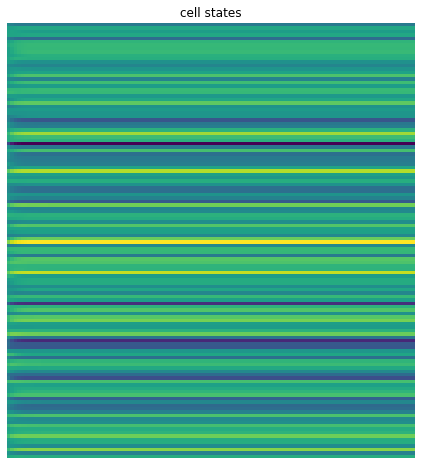

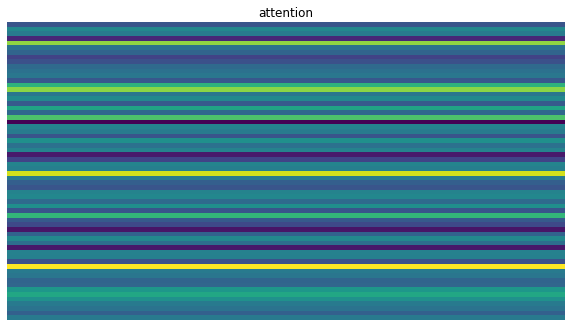

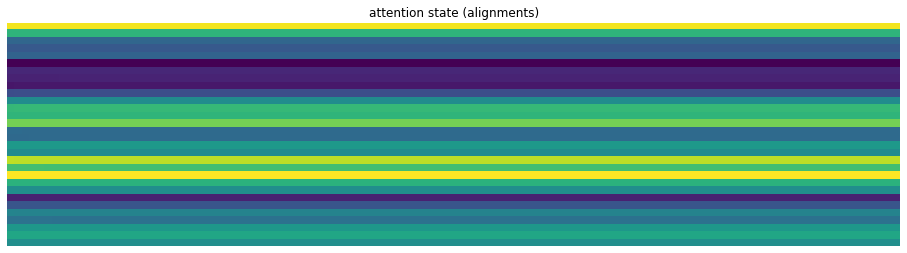

In [30]:
# TRAINED TTS
_, states = tts.decode(input, GEN_FRAMES // frames_per_step, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

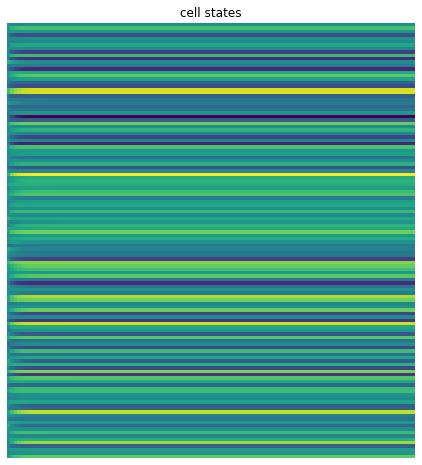

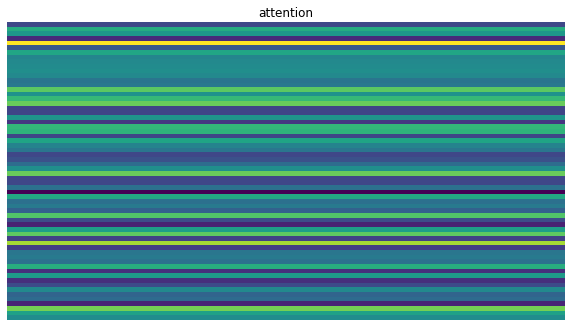

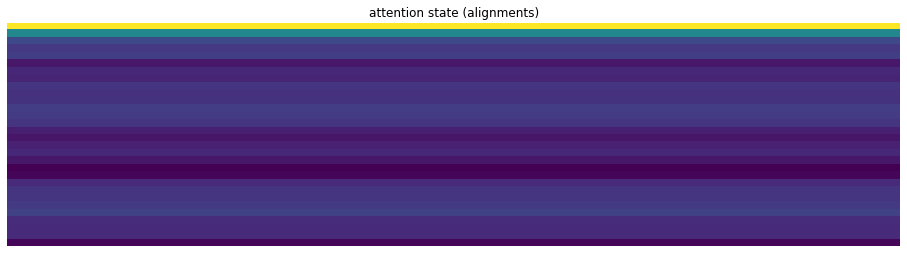

In [31]:
# TRAINED TTS epoch 0
_, states = tts_0.decode(input, GEN_FRAMES // frames_per_step, return_states=True)
att_rnn_states = [s[0] for s in states]
visualize_attention_states(att_rnn_states)

# Compare generated mel spectrogram to what is generated in training

In [40]:
tr_mel_spec, tr_enc_transcription = batch[1:3] # Get the relevant columns
tr_mel_spec = tr_mel_spec[:,:GEN_FRAMES, :]
tr_inp_mel_spec = tf.reshape(tr_mel_spec, (-1, GEN_FRAMES // frames_per_step, mel_bins * frames_per_step))
tr_inp_mel_spec = tr_inp_mel_spec[:, :-1, -mel_bins:] # use last frame as input
tr_inp_mel_spec = tf.pad(tr_inp_mel_spec, [(0, 0), (1,0), (0,0)]) # go frame

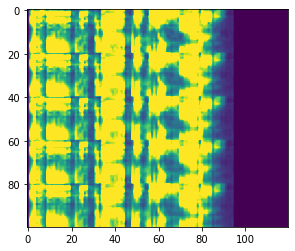

In [42]:
out = tts([tr_enc_transcription[:1], tr_inp_mel_spec[:1]])
plt.imshow(np.transpose(out[0]), vmax=1)

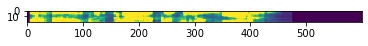

In [43]:
out = tf.reshape(out, (1, -1, mel_bins))
plt.imshow(np.transpose(out[0]), vmax=1)

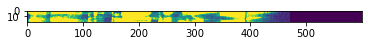

In [44]:
plt.imshow(np.transpose(tr_mel_spec[0]), vmax=1)

In [45]:
np.abs(out[0]-tr_mel_spec[0]).mean()

0.15713544

The model has generated a decent looking mel spectrogram, also the L1 loss looks pretty decent. It's a clear improvement over the epoch 0 model:

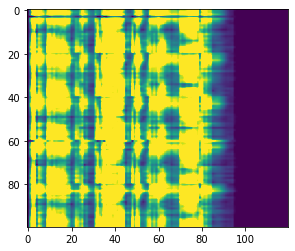

In [50]:
out_0 = tts_0([tr_enc_transcription[:1], tr_inp_mel_spec[:1]])
plt.imshow(np.transpose(out_0[0]), vmax=1)

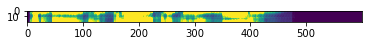

In [51]:
out_0 = tf.reshape(out_0, (1, -1, mel_bins))
plt.imshow(np.transpose(out_0[0]), vmax=1)

In [52]:
np.abs(out_0[0]-tr_mel_spec[0]).mean()

0.23704945

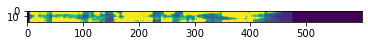

In [53]:
out = tts([tf.constant([[2,3,4,5,6,-1,-1]], dtype=tf.int64), tr_inp_mel_spec[:1]])
out = tf.reshape(out, (1, -1, mel_bins))
plt.imshow(np.transpose(out[0]), vmax=1)

In [54]:
np.abs(out[0]-tr_mel_spec[0]).mean()

0.15717618

The model is not using the transcription encoding. For the next time steps we will go closer to the Tacotron paper minus the linear spectrogram generator.

Also we need to check whether attention is working well.

Lastly, the values of the mel spectrogram should be brought into log scale.